## Preparation

In [ ]:
import os
!pip install torch torchvision torchaudio

import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install torch-sparse #-f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install torch-scatter #-f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

!pip install torch-geometric
!pip install codetiming
!pip install wandb
!pip install plotly
!pip install line-profiler

### Imports

In [121]:
import os
import pathlib

import codetiming
import numpy as np
import torch
import wandb

print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Loaded torch. Using *{device}* device.")

2.5.0+cu124
Loaded torch. Using *cuda* device.


### Load dataset

graphs_03.txt
graphs_04.txt
graphs_05.txt
graphs_06.txt
graphs_07.txt
graphs_08.txt
graphs_09.txt
graphs_10.txt
graphs_11.txt
graphs_12.txt
graphs_13.txt
graphs_14.txt
graphs_15.txt
graphs_20.txt
graphs_30.txt
graphs_40.txt
graphs_50.txt
graphs_10.txt
graphs_20.txt
Elapsed time: 0.0028 seconds

Dataset: MIDSdataset(992):
Number of graphs: 992
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 18], x=[7, 7], y=[7])
Number of nodes: 7
Number of edges: 18
Average node degree: 2.57
Has isolated nodes: False
Has self-loops: False
Is undirected: True


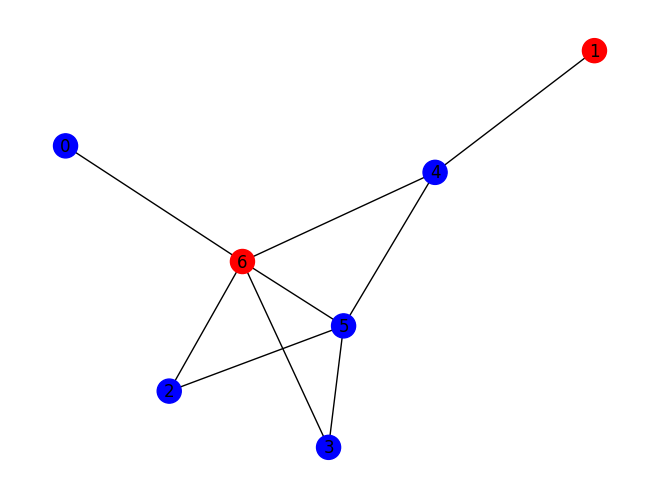

In [122]:
%run -i '/home/jovyan/MIDS-GNN/pyg_dataset.py'

In [123]:
from torch_geometric.loader import DataLoader
from my_graphs_dataset import GraphDataset

# Set up dataset.
selected_graph_sizes = {
    #3: -1,
    4: -1,
    5: -1,
    6: -1,
    7: -1,
    #8: -1,
    #9:  10000,
    #10: 1000,
    #11: 1000,
    #12: 1000,
    #13: 1000,
    #14: 1000,
    #15: 1000,
    #20: 2000,
    #30: 10000,
}
dataset_config = {
    "name": "MIDSdataset",
    "selected_graphs": str(selected_graph_sizes),
    "split": 0.8,
    "batch_size": 6000,
}

# Load the dataset.
root = "/home/jovyan/MIDS-GNN/Dataset"
graphs_loader = GraphDataset(selection=selected_graph_sizes)
dataset = MIDSdataset(root, graphs_loader)

# General information
print()
print(f"Dataset: {dataset}:")
print("====================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")

# Store information about the dataset.
dataset_config.update({"num_graphs": len(dataset)})#, "features": dataset.feature_functions})

# Shuffle and split the dataset.
torch.manual_seed(seed := 42)
dataset = dataset.shuffle()

train_size = round(dataset_config["split"] * len(dataset))
train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

print()
print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

# Batch and load data.
# TODO: Batch size?
batch_size = dataset_config["batch_size"] if dataset_config["batch_size"] > 0 else len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_batch = None
test_batch = None
# If the whole dataset fits in memory, we can use the following lines to get a single large batch.
#train_batch = next(iter(train_loader))
#test_batch = next(iter(test_loader))

#train_dataset = train_batch if train_batch is not None else train_loader
#test_dataset = test_batch if test_batch is not None else test_loader


graphs_03.txt
graphs_04.txt
graphs_05.txt
graphs_06.txt
graphs_07.txt
graphs_08.txt
graphs_09.txt
graphs_10.txt
graphs_11.txt
graphs_12.txt
graphs_13.txt
graphs_14.txt
graphs_15.txt
graphs_20.txt
graphs_30.txt
graphs_40.txt
graphs_50.txt
graphs_04.txt
graphs_05.txt
graphs_06.txt
graphs_07.txt

Dataset: MIDSdataset(992):
Number of graphs: 992
Number of features: 7

Number of training graphs: 794
Number of test graphs: 198


### Models

In [124]:
from torch_geometric.nn import GATConv
class Net(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, hidden_channels, heads=4)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * hidden_channels)
        self.conv2 = GATConv(4 * hidden_channels, hidden_channels, heads=4)
        self.lin2 = torch.nn.Linear(4 * hidden_channels, 4 * hidden_channels)
        self.conv3 = GATConv(4 * hidden_channels, hidden_channels, heads=4)
        self.lin3 = torch.nn.Linear(4 * hidden_channels, 4 * hidden_channels)
        self.conv5 = GATConv(4 * hidden_channels, hidden_channels, heads=4)
        self.lin5 = torch.nn.Linear(4 * hidden_channels, 4 * hidden_channels)
        self.conv4 = GATConv(4 * hidden_channels, 1, heads=6,
                             concat=False)
        self.lin4 = torch.nn.Linear(4 * hidden_channels, 1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = F.elu(self.conv3(x, edge_index) + self.lin3(x))
        #x = F.elu(self.conv5(x, edge_index) + self.lin5(x))
        x = self.conv4(x, edge_index) + self.lin4(x)
        return x.squeeze()

In [130]:
from torch_geometric.nn import GATConv, GINConv, GCNConv, GATv2Conv, ARMAConv
from torch_geometric.nn import global_mean_pool
class Net(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATv2Conv(train_dataset.num_features, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels)
        self.conv3 = ARMAConv(hidden_channels, hidden_channels)
        self.conv4 = GATv2Conv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)
        self.conv_last = GCNConv(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.lin1(x)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x.squeeze()

## Training & Evaluation

### Definitions

#### Training definitions

In [131]:
from torch_geometric.data import Data
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from torch import Tensor

from torch_sparse import SparseTensor

class CustomLossFunction(torch.nn.BCEWithLogitsLoss):
    """Custom loss function based on BCEWithLogitsLoss"""
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        tens = torch.split(target, input.size(dim=0))[0]
        loss = F.binary_cross_entropy_with_logits(input, tens, self.weight, pos_weight=self.pos_weight, reduction=self.reduction)
      
        for tens in torch.split(target, input.size(dim=0)):
            new = F.binary_cross_entropy_with_logits(input, tens, self.weight, pos_weight=self.pos_weight, reduction=self.reduction)
            if new.item() < loss.item():
                loss = new
        return loss


class UnsupervisedLossFunction(torch.nn.BCEWithLogitsLoss):

    def forward(self, A, candidate, target_value) -> Tensor:
        n = len(candidate)
        loss = torch.tensor(0.0, requires_grad=True)
    
        # loss for MIDS size
        loss = torch.add(loss, abs(sum(candidate) - target_value))
    
        # loss for domination
        for el in ((A + np.eye(n)) @ candidate):
            if el < 1: 
                loss = torch.add(loss, 1/n) # devide by factor (size)
    
        # loss for independance
        for i in range(n):
            for j in range(i+1, n):
                if candidate[i] and candidate[j] and A[i,j]:
                    loss = torch.add(loss, 1/n) # devide by factsor (size)
        return loss

def check_accuracy_unsupervised(data, out, criterion):
    pred = torch.where(out > 0, 1.0, 0.0)
    num_nodes = data.num_nodes 
    adjacency = SparseTensor(row=data.edge_index[0], col=data.edge_index[1], sparse_sizes=(num_nodes, num_nodes))
    adjacency_matrix = adjacency.to_dense()
    return criterion(adjacency_matrix.cpu().numpy(),
                                              out.detach().cpu().numpy(),
                                              sum(torch.split(data.y, data.num_nodes)[0].cpu().numpy()))


'''
def UnsupervisedLossFunction(A, candidate, target_value):
    n = len(candidate)
    loss = 0

    # loss for MIDS size
    loss += abs(sum(candidate) - target_value) 

    # loss for domination
    for el in ((A + np.eye(n)) @ candidate):
        if el < 1: 
            loss += 1/n # devide by factor (size)

    # loss for independance
    for i in range(n):
        for j in range(i+1, n):
            if candidate[i] and candidate[j] and A[i,j]:
                loss += 1/n # devide by factsor (size)
                
    return torch.tensor(loss, requires_grad=True)
'''

def check_MIDS(A, candidate, target_value):
    n = len(candidate)

    # Candidate set is larger than MIDS size
    if sum(candidate) > target_value:
        return False
        
    # Candidate set is not dominating
    if not all((A + np.eye(n)) @ candidate >= 1):
        return False

    # Candidate set is not independent
    for i in range(n):
        for j in range(i+1, n):
            if candidate[i] and candidate[j] and A[i,j]:
                return False

    #This case should never happen
    if sum(candidate) < target_value:
        print(f"Somehow we found an even smaller MIDS: {sum(candidate)}, {target_value}")
        pass

    return True

def generate_model(hidden_channels):
    """Generate a Neural Network model based on the architecture and hyperparameters."""
    model = Net(hidden_channels=hidden_channels).to(device)
    return model

def generate_optimizer(model, optimizer, lr):
    """Generate optimizer object based on the model and hyperparameters."""
    if optimizer == "adam":
        return torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("Only Adam optimizer is currently supported.")


def training_pass(model, batch, optimizer, criterion):
    """Perofrm a single training pass over the batch."""
    data = batch.to(device)
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x.type(torch.FloatTensor).to(device), data.edge_index, data.batch)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss.
    #loss = check_accuracy_unsupervised(batch, out, criterion)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

def check_accuracy(data, out):
    pred = torch.where(out > 0, 1.0, 0.0)
    num_nodes = data.num_nodes 
    adjacency = SparseTensor(row=data.edge_index[0], col=data.edge_index[1], sparse_sizes=(num_nodes, num_nodes))
    adjacency_matrix = adjacency.to_dense()
    return int(check_MIDS(adjacency_matrix.cpu().numpy(),
                                              pred.cpu().numpy(),
                                              sum(torch.split(data.y, data.num_nodes)[0].cpu().numpy())))


def testing_pass(model, batch, criterion):
    """Perform a single testing pass over the batch."""
    with torch.no_grad():
        data = batch.to(device)
        out = model(data.x.type(torch.FloatTensor).to(device), data.edge_index, data.batch)
        loss = criterion(out, data.y).item()  # Compute the loss.
        #loss = check_accuracy_unsupervised(data, out, criterion).item()
        acc = check_accuracy(data,out)
    return loss, acc


def do_train(model, data, optimizer, criterion):
    """Train the model on individual batches or the entire dataset."""
    model.train()

    for batch in data:  # Iterate in batches over the training dataset.
        training_pass(model, batch, optimizer, criterion)


def do_test(model, data, criterion):
    """Test the model on individual batches or the entire dataset."""
    model.eval()
    correct = 0
    losses = 0
    for batch in data:
        loss, acc = testing_pass(model, batch, criterion)
        correct += acc 
        losses += loss
    return losses/len(data), correct/len(data)*100

    


def train(model, optimizer, criterion, num_epochs=200, is_sweep=False):
    # GLOBALS: device, dataset, train_dataset, train_dataset

    # Prepare for training.
    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    # Start the training loop with timer.
    training_timer = codetiming.Timer(logger=None)
    epoch_timer = codetiming.Timer(logger=None)
    training_timer.start()
    epoch_timer.start()
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    for epoch in range(1, num_epochs + 1):
        # Perform one pass over the training set and then test on both sets.
        do_train(model, train_loader, optimizer, criterion)
        if epoch % 100 == 1 or epoch == 10000:
            train_loss, train_acc = do_test(model, train_dataset, criterion)
            test_loss, test_acc = do_test(model, test_dataset, criterion)

        # Store the losses.
        train_losses[epoch - 1] = train_loss
        test_losses[epoch - 1] = test_loss

        dur = epoch_timer.stop()
        print(
            f"Epoch: {epoch:03d}, "
            f"Train Loss: {train_loss:.4f}, "
            f"Test Loss: {test_loss:.4f}, "
            f"Train Accuracy: {train_acc:.4f}, "
            f"Test Accuracy: {test_acc:.4f}, "
            f"Avg. duration: {dur:.4f} s"
        )
        wandb.log({"train_loss": train_loss, "test_loss": test_loss,
                    "train_acc": train_acc, "test_acc": test_acc,
                    "train_loss_scaled": train_loss/0.8, "test_loss_scaled": test_loss/0.2,
                    "epoch_time": dur})
        epoch_timer.start()
    epoch_timer.stop()
    duration = training_timer.stop()

    results = {"train_losses": train_losses, "test_losses": test_losses, "duration": duration}
    return results, model

#### Evaluation definitions

In [132]:
import concurrent.futures

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from utils import create_graph_wandb, extract_graphs_from_batch, graphs_to_tuple


def plot_training_curves(num_epochs, train_losses, test_losses, criterion):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=train_losses, mode="lines", name="Train Loss"))
    fig.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=test_losses, mode="lines", name="Test Loss"))
    fig.update_layout(title="Training and Test Loss", xaxis_title="Epoch", yaxis_title=criterion)
    fig.show()


def evaluate(model, plot_graphs=False, is_sweep=False):
    # GLOBALS: dataset_config, train_loader, test_loader

    df = pd.DataFrame()

    # Evaluate the model on the test set.
    model.eval()
    with torch.no_grad():
        for data in test_loader:  # Iterate in batches over the training/test dataset.
            # Make predictions.
            data = data.to(device)
            out = model(data.x.type(torch.FloatTensor).to(device), data.edge_index)
            predictions = out.cpu().numpy().squeeze()
            ground_truth = data.y.cpu().numpy()

            # Extract graphs and create visualizations.
            nx_graphs = extract_graphs_from_batch(data)
            graphs, node_nums, edge_nums = zip(*graphs_to_tuple(nx_graphs))
            # FIXME: This is the only way to parallelize in Jupyter but runs out of memory.
            # with concurrent.futures.ProcessPoolExecutor(4) as executor:
            #     graph_visuals = executor.map(create_graph_wandb, nx_graphs, chunksize=10)
            if plot_graphs:
                graph_visuals = [create_graph_wandb(g) for g in nx_graphs]
            else:
                graph_visuals = ["N/A"] * len(nx_graphs)

            # Store to pandas DataFrame.
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        {
                            "GraphVis": graph_visuals,
                            "Graph": graphs,
                            "Nodes": node_nums,
                            "Edges": edge_nums,
                            "True": ground_truth,
                            "Predicted": predictions,
                        }
                    ),
                ]
            )

    # Calculate the statistics.
    df["Error"] = df["True"] - df["Predicted"]
    df["Error %"] = 100 * df["Error"] / df["True"]
    df["abs(Error)"] = np.abs(df["Error"])
    err_mean = np.mean(df["abs(Error)"])
    err_stddev = np.std(df["abs(Error)"])

    # Create a W&B table.
    table = wandb.Table(dataframe=df)

    # Print and plot.
    # df = df.sort_values(by="abs(Error)")
    fig_abs_err = px.histogram(df, x="Error")
    fig_rel_err = px.histogram(df, x="Error %")

    if not is_sweep:
        print(f"Mean error: {err_mean:.4f}\n" f"Std. dev.: {err_stddev:.4f}\n")
        fig_abs_err.show()
        fig_rel_err.show()
        df = df.sort_values(by="Nodes")
        print(df)

    results = {
        "mean_err": err_mean,
        "stddev_err": err_stddev,
        "fig_abs_err": fig_abs_err,
        "fig_rel_err": fig_rel_err,
        "table": table,
    }
    return results

#### Main definition

In [133]:
import wandb
device = "cuda" if torch.cuda.is_available() else "cpu"
def main(config=None, skip_evaluation=False):
    # GLOBALS: device, dataset, train_dataset, test_dataset

    is_sweep = config is None

    # Set up the run
    run = wandb.init(project="GNN_MIDS", config=config)
    config = wandb.config
    if is_sweep:
        print(f"Running sweep with config: {config}...")

    # Set up the model, optimizer, and criterion.
    model = generate_model(config["hidden_channels"])
    optimizer = generate_optimizer(model, config["optimizer"], config["learning_rate"])
    criterion = CustomLossFunction()
    criterion = torch.nn.BCEWithLogitsLoss()
    #criterion = UnsupervisedLossFunction()

    # Run training.
    print("Training started")
    train_results, model = train(model, optimizer, criterion, config["epochs"], is_sweep=is_sweep)
    run.summary["best_train_loss"] = min(train_results["train_losses"])
    run.summary["best_test_loss"] = min(train_results["test_losses"])
    run.summary["duration"] = train_results["duration"]
    if not is_sweep:
        plot_training_curves(
            config["epochs"], train_results["train_losses"], train_results["test_losses"], type(criterion).__name__
        )

    return run, model

### Run

#### Standard run

In [135]:

global_config = {
    "seed": seed,
    "dataset": dataset_config,
    "hidden_channels": 64,
    "optimizer": "adam",
    "learning_rate": 0.0003,
    "epochs": 3200,
    "layers": "4",
    "architecture": "GAT",
    "batch": "yes",
    "solutions": "one",
}
run, model = main(global_config)
#torch.save(model, '/home/jovyan/models/42000_lr-0001_lf-multi_8f_lay-4.pth')

epoch_time,▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▁▅▅▆▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇███▇▇▇▆▆▆▆▆▆▇▇▇▇▇▆▆▆
test_loss,████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▂▂▃▃▃▃▃▄▄▄▄
test_loss_scaled,██▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄
train_acc,▁▁▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇███████████████
train_loss,██▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_scaled,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
best_test_loss,0.2922
best_train_loss,0.16111
duration,186.89037
epoch_time,0.02781


Training started
Epoch: 001, Train Loss: 0.6857, Test Loss: 0.6857, Train Accuracy: 0.0000, Test Accuracy: 0.0000, Avg. duration: 2.7301 s
Epoch: 002, Train Loss: 0.6857, Test Loss: 0.6857, Train Accuracy: 0.0000, Test Accuracy: 0.0000, Avg. duration: 0.0284 s
Epoch: 003, Train Loss: 0.6857, Test Loss: 0.6857, Train Accuracy: 0.0000, Test Accuracy: 0.0000, Avg. duration: 0.0276 s
Epoch: 004, Train Loss: 0.6857, Test Loss: 0.6857, Train Accuracy: 0.0000, Test Accuracy: 0.0000, Avg. duration: 0.0274 s
Epoch: 005, Train Loss: 0.6857, Test Loss: 0.6857, Train Accuracy: 0.0000, Test Accuracy: 0.0000, Avg. duration: 0.0273 s
Epoch: 006, Train Loss: 0.6857, Test Loss: 0.6857, Train Accuracy: 0.0000, Test Accuracy: 0.0000, Avg. duration: 0.0268 s
Epoch: 007, Train Loss: 0.6857, Test Loss: 0.6857, Train Accuracy: 0.0000, Test Accuracy: 0.0000, Avg. duration: 0.0275 s
Epoch: 008, Train Loss: 0.6857, Test Loss: 0.6857, Train Accuracy: 0.0000, Test Accuracy: 0.0000, Avg. duration: 0.0272 s
Epoch: 

In [ ]:
torch.save(model, '/home/jovyan/models/10_do_15.pth')

In [ ]:
model = torch.load('/home/jovyan/models/10_i_20.pth')


def get_highest_n_positions(array, n):
    # Convert the array to a numpy array for easy manipulation
    array = np.array(array)
    
    # Get the indices of the n highest values
    highest_indices = np.argsort(array)[-n:]
    
    # Create a new array of zeros with the same length
    result = np.zeros_like(array)
    
    # Set ones at the positions of the highest values
    result[highest_indices] = 1
    
    return result
    

def check_MIDS_test(A, candidate, target_value, out):
    n = len(candidate)
    loss = 0
    # Candidate set is not minimal
    if sum(candidate) > target_value:
        return False# not minimal

    # Candidate set is not dominating and independent
    if not all((A + np.eye(n)) @ candidate >= 1): # domination 
        return False
    
    for el in ((A + np.eye(n)) @ candidate):
        if el < 1: 
            loss += 1

    for i in range(n):
        for j in range(i+1, n):
            if candidate[i] and candidate[j] and A[i,j]: # independancy
                return False # TODO: zbrajati koliko ih ima koji ispunjavaju uvijet - iz tog dobiti mjeru (LOSS) nezavisnosti
                
    if sum(candidate) < target_value:
        print(f"Somehow we found an even smaller MIDS: {sum(candidate)}, {target_value}")
        pass

    return True


@torch.no_grad()
def test(loader):
    model.eval()
    flag = 0
    correct = 0
    correct_checkMIDS = 0
    correct_checkMIDS_new = 0
    not_min = 0
    one_less = 0
    off_by_one = 0
    for i, data in enumerate(loader):
        for idx in range(data.num_graphs):
            out = model(data.get_example(idx).x.type(torch.FloatTensor).to(device), data.get_example(idx).edge_index.to(device))
            #print(out)
            pred = torch.where(out > 0, 1.0, 0.0)
            #print(data.edge_index)

            #correct += int(torch.equal(pred.to(device),data.get_example(idx).y.type(torch.LongTensor).to(device)))  # Derive ratio of correct predictions.

            num_nodes = data.get_example(idx).num_nodes
            adjacency = SparseTensor(row=data.get_example(idx).edge_index[0], col=data.get_example(idx).edge_index[1], sparse_sizes=(num_nodes, num_nodes))
            adjacency_matrix = adjacency.to_dense()
            correct = check_MIDS_test(adjacency_matrix.numpy(),
                                pred.cpu().numpy(),
                                sum(torch.split(data.get_example(idx).y, data.num_nodes)[0].cpu().numpy()), out)
            correct_new = check_MIDS_test(adjacency_matrix.numpy(),
                                get_highest_n_positions(out.cpu(), int(sum(torch.split(data.get_example(idx).y, data.num_nodes)[0].cpu().numpy()))),
                                sum(torch.split(data.get_example(idx).y, data.num_nodes)[0].cpu().numpy()), out)

            correct_checkMIDS_new += int(correct_new)
            if correct == True:
                correct_checkMIDS += int(correct)
            else:
                if correct == -5: # not minimal
                    not_min += 1
                if correct == -4: # 1 less
                    one_less += 1
                    #print(get_highest_n_positions(out.cpu(), int(sum(pred).cpu())+1))
                    off_by_one += check_MIDS_test(adjacency_matrix.numpy(),
                                get_highest_n_positions(out.cpu(), int(sum(pred).cpu())+1),
                                sum(torch.split(data.get_example(idx).y, data.num_nodes)[0].cpu().numpy()), out)
                    

    #print(f'{correct_checkMIDS/len(loader.dataset)*100}%')
    print(correct_checkMIDS)
    print(len(loader.dataset))
    return correct_checkMIDS/len(loader.dataset)*100, correct_checkMIDS_new/len(loader.dataset)*100#, not_min/len(loader.dataset)*100, one_less/len(loader.dataset)*100, off_by_one/len(loader.dataset)*100


root = "/home/jovyan/MIDS-GNN/Dataset"
graphs_loader = GraphDataset(selection=selected_graph_sizes)
dataset = MIDSdataset(root, graphs_loader)

loader = DataLoader(dataset, batch_size=1, shuffle=False)
test(loader)

In [ ]:
def examine_pred(data, pred):
    G = pygUtils.to_networkx(data, to_undirected=True)
    nx.draw(G, with_labels=True, node_color=pred, cmap=matplotlib.colormaps["bwr"])
    plt.show()
    print(f'prediction: {pred}')
    print(f'data.y:     {torch.split(data.y, data.num_nodes)}')

for i in range(50):
    d = dataset[i]
    out = model(d.x.type(torch.FloatTensor).to(device), d.edge_index.to(device))
    pred = torch.where(out > 0, 1.0, 0.0)
    num_nodes = d.num_nodes
    adjacency = SparseTensor(row=d.edge_index[0], col=d.edge_index[1], sparse_sizes=(num_nodes, num_nodes))
    adjacency_matrix = adjacency.to_dense()
    correct = check_MIDS_test(adjacency_matrix.numpy(),
                                get_highest_n_positions(out.cpu(), int(sum(torch.split(d.y, d.num_nodes)[0].cpu()))),
                                sum(torch.split(d.y, data.num_nodes)[0].cpu()), out)

    if correct == False:
        examine_pred(d.cpu(), pred.cpu())
        print(model(d.x.type(torch.FloatTensor).to(device), d.edge_index.to(device)))

#### W&B sweep

In [ ]:
#%env WANDB_SILENT=True

import time
time.sleep(2)

# TODO: How to include seed and dataset configuration?

full_sweep_configuration = {
    "name": "full_first_sweep",
    "method": "grid",  # grid, random or Bayesian
    "metric": {"goal": "minimize", "name": "test_loss"},
    "parameters": {
        "architecture": {"value": "GAT"},
        "hidden_channels": {"values": [256]},
        "optimizer": {"value": "adam"},
        "learning_rate": {"values": [0.0002, 0.0004, 0.0006]},
        "epochs": {"value": 150}
    },
    "early_terminate": {
        "type": "hyperband",
        "eta": 3,
        "min_iter": 150
    }
}

test_sweep_configuration = {
    "name": "test_sweep",
    "method": "grid",  # grid, random or Bayesian
    "metric": {"goal": "minimize", "name": "test_loss"},
    "parameters": {
        "architecture": {"values": ["GCN", "GAT"]},
        "hidden_channels": {"values": [8, 16]},
        "num_layers": {"values": [2, 5]},
        "optimizer": {"value": "adam"},
        "learning_rate": {"values": [0.01, 0.001]},
        "epochs": {"value": 1000}
    },
}

sweep_id = wandb.sweep(sweep=full_sweep_configuration, project="GNN_MIDS")

wandb.agent(sweep_id, function=main, count=3)



In [ ]:
wandb.agent(sweep_id, function=main, count=4)

In [ ]:
# Stop the W&B run.
run.finish()

## Housekeeping

### Save the model

In [ ]:
# torch.save(model.state_dict(), "model.pth")
# print("Saved PyTorch Model State to model.pth")


### Make predictions with loaded model

In [ ]:
# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

# classes = [
#     "T-shirt/top",
#     "Trouser",
#     "Pullover",
#     "Dress",
#     "Coat",
#     "Sandal",
#     "Shirt",
#     "Sneaker",
#     "Bag",
#     "Ankle boot",
# ]

# model.eval()
# x, y = test_data[0][0], test_data[0][1]
# with torch.no_grad():
#     x = x.to(device)
#     pred = model(x)
#     predicted, actual = classes[pred[0].argmax(0)], classes[y]
#     print(f'Predicted: "{predicted}", Actual: "{actual}"')

## Additional W&B APIs

In [ ]:
# api = wandb.Api()

# # Access attributes directly from the run object
# # or from the W&B App
# username = "marko-krizmancic"
# project = "gnn_fiedler_approx"
# run_id = ["nrcdc1y4", "11l94b1a", "ptj7b0vx"]

# for id in run_id:
#     run = api.run(f"{username}/{project}/{id}")
#     run.config["model"] = "GCN"
#     run.update()